In [1]:
# Import the required packages and libraries
from PIL import Image
import numpy as np
import mpeg_I_picture
import assignment_utils
import time

## IP GOP for Exhaustive Search

Create an I-Picture reference

In [2]:
def create_I_reference(image, scaling):
    i_picture = mpeg_I_picture.code_picture(image, scaling)
    return mpeg_I_picture.reconstruct_picture(image.size, i_picture, scaling)

Motion Compensation Process
- Motion estimation
- Motion compensated reference
- Coding mode decisions (if intra mode, a motion vector)
- In this practical all macroblocks will be coded in inter-mode (i.e. predicted)

The P-picture process
- Motion estimation
- Search strategy using a previous picture as the reference
    - Exhaustive, but within a search window
- Match function
    - Sum of absolute differences (fast)

In [3]:
def search_window(x, y, window, picture_size):
    '''A search window centred on the position of the target macroblock'''
    # tedious detail - define a search window, but make sure it stays within the reference picture
    s_x = max(x - window[0], 0)
    e_x = min(x + window[0], picture_size[0])
    s_y = max(y - window[1], 0)
    e_y = min(y + window[1], picture_size[1])

    return (s_x, s_y, e_x, e_y)

In [4]:
def SAD(candidate, target):
    '''sum of absolute differences (fast)'''
    # subtract the luma component of the candidate block and the the target block
    # worry about overflow as image data is unsigned byte [0..255] so convert to float
    return np.sum(np.absolute(np.asarray(candidate).astype(float) - np.asarray(target).astype(float)))

In [5]:
def motion_vector(target_mb, reference, mb_position, window_size):
    (x0, y0) = mb_position
    
    best_difference = 255 * 16 * 16 + 1    # each luma component is as different as possible + 1
    best_i = best_j = 0
    
    # a simple optimisation is to skip search if difference with no displacement (0,0) is below a threshold
    # or if this threshold is discovered during the search (exit early from the loop)
    
    (s_x, s_y, e_x, e_y) = search_window(x0, y0, window_size, reference.size)
        
    for y in range(s_y, e_y):
        for x in range(s_x, e_x):
            c_mb = reference.crop((x, y, x + 16, y + 16))
            d = SAD(c_mb, target_mb)
            
            if d < best_difference:
                best_difference = d
                best_i = x - x0
                best_j = y - y0
           
    return (best_i, best_j)

- An encoding application is free to implement motion estimation anyway it chooses  
- Motion Compensation uses the results of the Motion Estimation  
- Create a motion compensated picture from the reference  
- Differences are coded from this picture

In [6]:
def motion_estimation(target, reference, window_size):
    (width, height) = target.size
    motion_vectors = np.empty((height // 16, width // 16), object)
    num_candidates = 0
    start_time = time.time()
    for y in range(0, height, 16):
        for x in range(0, width, 16):
            target_mb = target.crop((x, y, x+16, y+16))
            mv = motion_vector(target_mb, reference, (x,y), window_size)
            motion_vectors[y // 16, x // 16] = mv
            num_candidates += (1 + (2 * window_size[0]) * (2 * window_size[1]))
    end_time = time.time()
    execution_time = end_time - start_time
    return motion_vectors, execution_time, num_candidates

In [7]:
def motion_compensated_reference(motion_vectors, reference):
    mc_reference = Image.new('L', reference.size)  # it will be a luma image also
    
    (width, height) = reference.size
    
    for y in range(0, height, 16):  # step through the image in macroblock steps (16x16)
        for x in range(0, width, 16):
            (d_x, d_y) = motion_vectors[y // 16, x // 16]
            mc_mb = reference.crop((x + d_x, y + d_y, x + d_x + 16, y + d_y + 16))
            mc_reference.paste(mc_mb, (x, y, x + 16, y + 16))
            
    return mc_reference

Example: Coding an MPEG-1 P-picture using an I-Picture reference
- GOP structure IP
- match function SAD
- search strategy (exhaustive search)
- search window a configuration parameter here it is (10, 5)

In [72]:
# Using the stefan sequence
# Exploring the IP GOP, so the reference is the first picture and the target is the second picture
REFERENCE_IP_ES = Image.open('Assets/Pictures/coastguard-060.png')
TARGET_IP_ES = Image.open('Assets/Pictures/coastguard-061.png')

In [73]:
reference_ip_es = create_I_reference(REFERENCE_IP_ES, scaling=10)

In [74]:
reference_luma_ip_es = reference_ip_es.split()[0]

In [75]:
target_luma_ip_es = TARGET_IP_ES.convert('YCbCr').split()[0]

In [76]:
WINDOW_SIZE = (12, 5)

Extract the motion vectors

In [77]:
motion_vectors_ip_es, execution_time_ip_es, num_candidates_ip_es = motion_estimation(TARGET_IP_ES, REFERENCE_IP_ES, WINDOW_SIZE)

print("Execution time:", execution_time_ip_es, "seconds")
print("Number of candidates considered:", num_candidates_ip_es)

Execution time: 1.1475017070770264 seconds
Number of candidates considered: 95436


Create the Motion Compensated Reference

In [78]:
mc_reference_luma_ip_es = motion_compensated_reference(motion_vectors_ip_es, reference_luma_ip_es)

Compare the Performance 
- Motion Compensated Reference
- Non-motion compensated reference

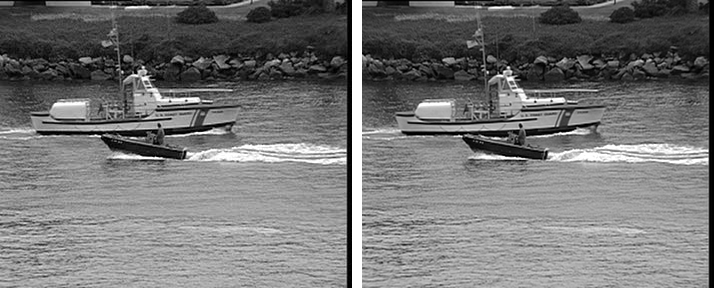

In [79]:
assignment_utils.side_by_side(reference_luma_ip_es, target_luma_ip_es)

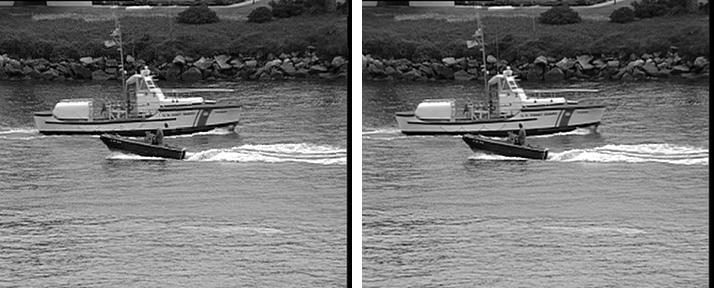

In [80]:
assignment_utils.side_by_side(mc_reference_luma_ip_es, target_luma_ip_es)

In [81]:
difference_image_IP_ES=assignment_utils.difference_image(reference_luma_ip_es, mc_reference_luma_ip_es)

In [82]:
difference_image_IP_ES.save('Assets/Differences/difference_image_ip_es_costguard.png')

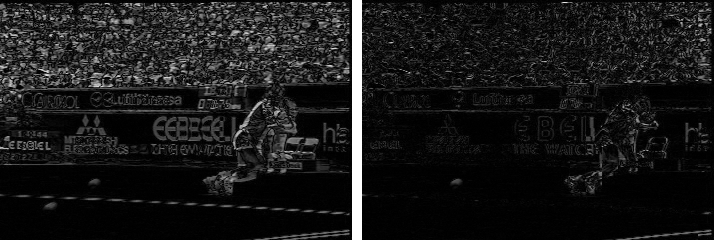

In [20]:
assignment_utils.side_by_side(assignment_utils.difference_image(target_luma_ip_es, reference_luma_ip_es), \
                              assignment_utils.difference_image(target_luma_ip_es, mc_reference_luma_ip_es))

Using an objective Metric (PSNR)

In [20]:
assignment_utils.image_psnr(reference_luma_ip_es, target_luma_ip_es)

14.70849104915916

In [21]:
assignment_utils.image_psnr(mc_reference_luma_ip_es, target_luma_ip_es)

20.681892279201218

## IBBP Structure for Exhaustive Search

In [83]:
# This caters to 2 middle pictures in the sequence for the bidirectional part

def bidirectional_motion_vector(target_mb, reference1, reference2, mb_position, window_size):
    (x0, y0) = mb_position
    
    best_difference = 255 * 16 * 16 + 1
    best_i1 = best_j1 = best_i2 = best_j2 = 0
    
    (s_x, s_y, e_x, e_y) = search_window(x0, y0, window_size, reference1.size)
        
    for y in range(s_y, e_y):
        for x in range(s_x, e_x):
            c_mb = reference1.crop((x, y, x + 16, y + 16))
            d = SAD(c_mb, target_mb)
            
            if d < best_difference:
                best_difference = d
                best_i1 = x - x0
                best_j1 = y - y0
    
    best_difference = 255 * 16 * 16 + 1
    
    (s_x, s_y, e_x, e_y) = search_window(x0, y0, window_size, reference2.size)
        
    for y in range(s_y, e_y):
        for x in range(s_x, e_x):
            c_mb = reference2.crop((x, y, x + 16, y + 16))
            d = SAD(c_mb, target_mb)
            
            if d < best_difference:
                best_difference = d
                best_i2 = x - x0
                best_j2 = y - y0
           
    return ((best_i1, best_j1), (best_i2, best_j2))

In [84]:
def bidirectional_motion_estimation(target, reference1, reference2, window_size):
    (width, height) = target.size
    motion_vectors = np.empty((height // 16, width // 16), object)
    num_candidates = 0
    start_time = time.time()
    
    for y in range(0, height, 16):
        for x in range(0, width, 16):
            target_mb = target.crop((x, y, x+16, y+16))
            mv = bidirectional_motion_vector(target_mb, reference1, reference2, (x,y), window_size)
            motion_vectors[y // 16, x // 16] = mv
            num_candidates += (1 + (2 * window_size[0]) * (2 * window_size[1])) * 2  # Multiply by 2 for bidirectional
    end_time = time.time()
    execution_time = end_time - start_time
    
    return motion_vectors, execution_time, num_candidates

In [27]:
def motion_compensated_reference_b(motion_vectors, reference1, reference2):
    mc_reference = Image.new('L', reference1.size)
    
    (width, height) = reference1.size
    
    for y in range(0, height, 16):
        for x in range(0, width, 16):
            (d_x1, d_y1), (d_x2, d_y2) = motion_vectors[y // 16, x // 16]
            mc_mb_ref1 = reference1.crop((x + d_x1, y + d_y1, x + d_x1 + 16, y + d_y1 + 16))
            mc_mb_ref2 = reference2.crop((x + d_x2, y + d_y2, x + d_x2 + 16, y + d_y2 + 16))
            mc_mb = Image.blend(mc_mb_ref1, mc_mb_ref2, alpha=0.5)  # Blending for B-picture
            mc_reference.paste(mc_mb, (x, y, x + 16, y + 16))
            
    return mc_reference

In [93]:
# Load images
REFERENCE_1_IBBP_ES = Image.open('Assets/Pictures/container-257.png')
REFERENCE_2_IBBP_ES = Image.open('Assets/Pictures/container-258.png')
REFERENCE_3_IBBP_ES = Image.open('Assets/Pictures/container-259.png')
TARGET_IBBP_ES = Image.open('Assets/Pictures/container-260.png')

# Create I reference
reference1_ibbp_es = create_I_reference(REFERENCE_1_IBBP_ES, scaling=10)
reference_luma1_ibbp_es = reference1_ibbp_es.split()[0]

# Convert B references and Target to luma
reference_luma2_ibbp_es = REFERENCE_2_IBBP_ES.convert('YCbCr').split()[0]
reference_luma3_ibbp_es = REFERENCE_3_IBBP_ES.convert('YCbCr').split()[0]
target_luma_ibbp_es = TARGET_IBBP_ES.convert('YCbCr').split()[0]

WINDOW_SIZE = (12, 5)

# Motion estimation for B-Pictures
motion_vectors_ibbp_es, execution_time_ibbp_es, num_candidates_ibbp_es = bidirectional_motion_estimation(target_luma_ibbp_es, reference_luma2_ibbp_es, reference_luma3_ibbp_es, WINDOW_SIZE)
mc_reference_luma_b = motion_compensated_reference_b(motion_vectors_ibbp_es, reference_luma2_ibbp_es, reference_luma3_ibbp_es)
print("Execution time:", execution_time_ibbp_es, "seconds")
print("Number of candidates considered:", num_candidates_ibbp_es)

Execution time: 1.7947440147399902 seconds
Number of candidates considered: 190872


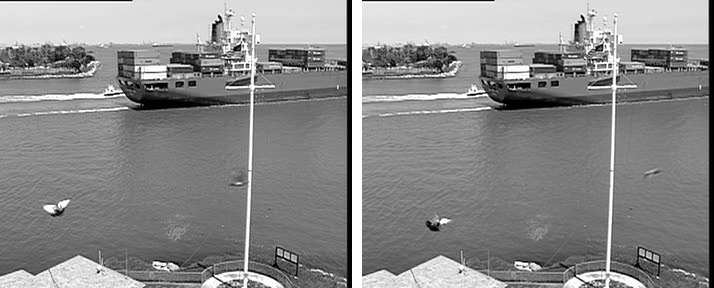

In [94]:
assignment_utils.side_by_side(reference_luma1_ibbp_es, target_luma_ibbp_es)

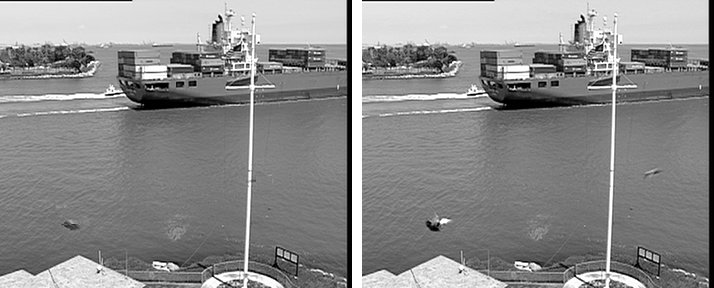

In [95]:
assignment_utils.side_by_side(mc_reference_luma_b, target_luma_ibbp_es)

In [96]:
difference_image_IBBP_ES=assignment_utils.difference_image(reference_luma1_ibbp_es, mc_reference_luma_b)
difference_image_IBBP_ES.save('Assets/Differences/difference_image_ibbp_es_container.png')

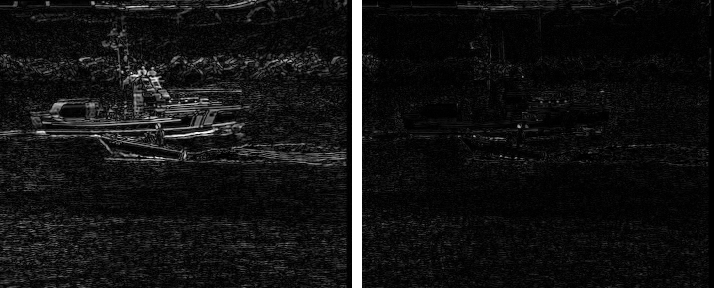

In [89]:
assignment_utils.side_by_side(assignment_utils.difference_image(target_luma_ibbp_es, reference_luma1_ibbp_es), \
                              assignment_utils.difference_image(target_luma_ibbp_es, mc_reference_luma_b))

In [90]:
assignment_utils.image_psnr(reference_luma1_ibbp_es, target_luma_ibbp_es)

17.25066876765974

In [35]:
assignment_utils.image_psnr(mc_reference_luma_b, target_luma_ibbp_es)

18.194586387253967

## IP GOP for Diamond Search

In [97]:
def motion_vector_ds(target_mb, reference, mb_position, window_size):
    (x0, y0) = mb_position
    
    best_difference = 255 * 16 * 16 + 1    # each luma component is as different as possible + 1
    best_i = best_j = 0
    
    (s_x, s_y, e_x, e_y) = search_window(x0, y0, window_size, reference.size)
    
    # Initialize the diamond search pattern
    diamond_pattern = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
    diamond_step = 8  # Initial diamond step size
    
    # Perform UCBDS
    while diamond_step >= 1:
        for (dx, dy) in diamond_pattern:
            cx, cy = x0 + dx * diamond_step, y0 + dy * diamond_step
            if s_x <= cx < e_x and s_y <= cy < e_y:
                c_mb = reference.crop((cx, cy, cx + 16, cy + 16))
                d = SAD(c_mb, target_mb)
                if d < best_difference:
                    best_difference = d
                    best_i = cx - x0
                    best_j = cy - y0

        # Update the diamond step size
        diamond_step //= 2
        # Recalculate diamond pattern with the new step size
        diamond_pattern = [(dx * 2, dy * 2) for (dx, dy) in diamond_pattern]

    return (best_i, best_j)

In [98]:
def motion_estimation_ds(target, reference, window_size):
    
    (width, height) = target.size
    motion_vectors = np.empty((height // 16, width // 16), object)
    num_candidates = 0
    start_time = time.time()
    for y in range(0, height, 16):
        for x in range(0, width, 16):
            target_mb = target.crop((x, y, x+16, y+16))
            mv = motion_vector(target_mb, reference, (x,y), window_size)
            motion_vectors[y // 16, x // 16] = mv
            num_candidates += (1 + (2 * window_size[0]) * (2 * window_size[1]))
    end_time = time.time()
    execution_time = end_time - start_time
    return motion_vectors, execution_time, num_candidates

In [38]:
def motion_compensated_reference_ds(motion_vectors, reference):
    
    mc_reference = Image.new('L', reference.size)  # it will be a luma image also
    
    (width, height) = reference.size
    
    for y in range(0, height, 16):  # step through the image in macroblock steps (16x16)
        for x in range(0, width, 16):
            (d_x, d_y) = motion_vectors[y // 16, x // 16]
            mc_mb = reference.crop((x + d_x, y + d_y, x + d_x + 16, y + d_y + 16))
            mc_reference.paste(mc_mb, (x, y, x + 16, y + 16))
            
    return mc_reference

In [108]:
# Using the stefan sequence

# Exploring the IP GOP, so the reference is the first picture and the target is the second picture
REFERENCE_IP_DS = Image.open('Assets/Pictures/stefan-174.png')
TARGET_IP_DS = Image.open('Assets/Pictures/stefan-175.png')

In [109]:
reference_ip_ds = create_I_reference(REFERENCE_IP_DS, scaling=10)

In [110]:
reference_luma_ip_ds = reference_ip_ds.split()[0]

In [111]:
target_luma_ip_ds = TARGET_IP_DS.convert('YCbCr').split()[0]

In [112]:
motion_vectors1, execution_time1, num_candidates1 = motion_estimation_ds(TARGET_IP_DS, REFERENCE_IP_DS, WINDOW_SIZE)

print("Execution time:", execution_time1, "seconds")
print("Number of candidates considered:", num_candidates1)

Execution time: 0.9456980228424072 seconds
Number of candidates considered: 79530


In [113]:
mc_reference_luma_ds = motion_compensated_reference_ds(motion_vectors1, reference_luma_ip_ds)

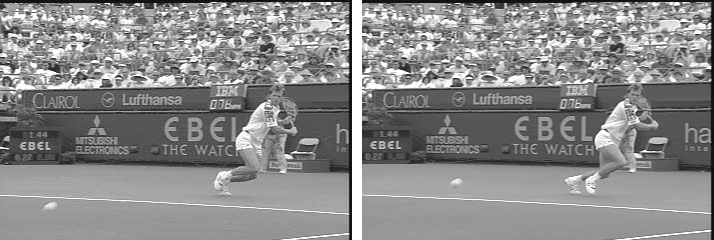

In [114]:
assignment_utils.side_by_side(reference_luma_ip_ds, target_luma_ip_ds)

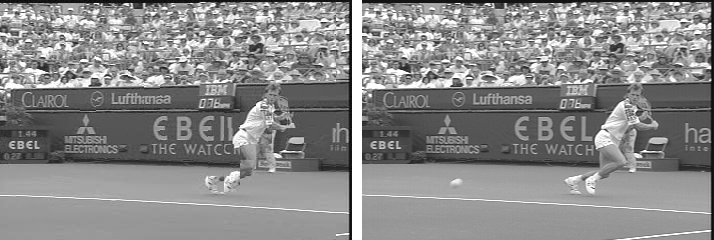

In [115]:
assignment_utils.side_by_side(mc_reference_luma_ds, target_luma_ip_ds)

In [116]:
difference_image_IP_DS=assignment_utils.difference_image(reference_luma_ip_ds, mc_reference_luma_ds)
difference_image_IP_DS.save('Assets/Differences/difference_image_ip_ds_stefan.png')

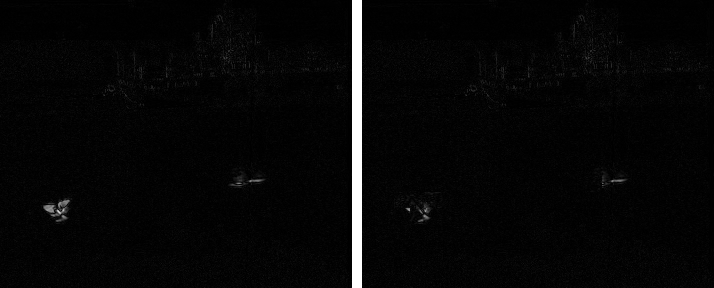

In [49]:
assignment_utils.side_by_side(assignment_utils.difference_image(target_luma_ip_ds, reference_luma_ip_ds), \
                              assignment_utils.difference_image(target_luma_ip_ds, mc_reference_luma_ds))

In [50]:
assignment_utils.image_psnr(reference_luma_ip_ds, target_luma_ip_ds)

30.935735090300977

In [51]:
assignment_utils.image_psnr(mc_reference_luma_ds, target_luma_ip_ds)

33.24848239722085

## IBBP GOP for Diamond Search

In [117]:
def bidirectional_motion_vector_ucbds(target_mb, reference1, reference2, mb_position, window_size):
    (x0, y0) = mb_position
    
    best_difference1 = best_difference2 = 255 * 16 * 16 + 1
    best_i1 = best_j1 = best_i2 = best_j2 = 0
    
    (s_x, s_y, e_x, e_y) = search_window(x0, y0, window_size, reference1.size)
    
    # UCBDS for reference1
    diamond_step = 8
    diamond_pattern = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while diamond_step >= 1:
        for (dx, dy) in diamond_pattern:
            cx, cy = x0 + dx * diamond_step, y0 + dy * diamond_step
            if s_x <= cx < e_x and s_y <= cy < e_y:
                c_mb = reference1.crop((cx, cy, cx + 16, cy + 16))
                d = SAD(c_mb, target_mb)
                if d < best_difference1:
                    best_difference1 = d
                    best_i1 = cx - x0
                    best_j1 = cy - y0

        diamond_step //= 2
        diamond_pattern = [(dx * 2, dy * 2) for (dx, dy) in diamond_pattern]
    
    # UCBDS for reference2
    (s_x, s_y, e_x, e_y) = search_window(x0, y0, window_size, reference2.size)
    
    diamond_step = 8
    diamond_pattern = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while diamond_step >= 1:
        for (dx, dy) in diamond_pattern:
            cx, cy = x0 + dx * diamond_step, y0 + dy * diamond_step
            if s_x <= cx < e_x and s_y <= cy < e_y:
                c_mb = reference2.crop((cx, cy, cx + 16, cy + 16))
                d = SAD(c_mb, target_mb)
                if d < best_difference2:
                    best_difference2 = d
                    best_i2 = cx - x0
                    best_j2 = cy - y0

        diamond_step //= 2
        diamond_pattern = [(dx * 2, dy * 2) for (dx, dy) in diamond_pattern]
    
    return ((best_i1, best_j1), (best_i2, best_j2))

In [118]:
# Modify the motion estimation function to use UCBDS for both references
def bidirectional_motion_estimation_ucbds(target, reference1, reference2, window_size):
    (width, height) = target.size
    motion_vectors = np.empty((height // 16, width // 16), object)
    num_candidates = 0
    start_time = time.time()
    
    for y in range(0, height, 16):
        for x in range(0, width, 16):
            target_mb = target.crop((x, y, x+16, y+16))
            mv = bidirectional_motion_vector_ucbds(target_mb, reference1, reference2, (x,y), window_size)
            motion_vectors[y // 16, x // 16] = mv
            num_candidates += (1 + (2 * window_size[0]) * (2 * window_size[1])) * 2  # Multiply by 2 for bidirectional
    end_time = time.time()
    execution_time = end_time - start_time
    
    return motion_vectors, execution_time, num_candidates


In [126]:
# Load images
REFERENCE_DS1_IBBP = Image.open('Assets/Pictures/stefan-174.png')
REFERENCE_DS2_IBBP = Image.open('Assets/Pictures/stefan-175.png')
REFERENCE_DS3_IBBP = Image.open('Assets/Pictures/stefan-176.png')
TARGET_DS_IBBP = Image.open('Assets/Pictures/stefan-177.png')

# Create I reference
reference_ds1_ibbp = create_I_reference(REFERENCE_DS1_IBBP, scaling=10)
reference_luma_ds1_ibbp = reference_ds1_ibbp.split()[0]

# Convert B references and Target to luma
reference_luma_ds2_ibbp = REFERENCE_DS2_IBBP.convert('YCbCr').split()[0]
reference_luma_ds3_ibbp = REFERENCE_DS3_IBBP.convert('YCbCr').split()[0]
target_luma_ds_ibbp = TARGET_DS_IBBP.convert('YCbCr').split()[0]

WINDOW_SIZE = (12, 5)

# Motion estimation for B-Pictures using UCBDS
motion_vectors_b_ucbds, execution_time_ucbds, num_candidates_ucbds = bidirectional_motion_estimation_ucbds(target_luma_ds_ibbp, reference_luma_ds2_ibbp, reference_luma_ds3_ibbp, WINDOW_SIZE)
mc_reference_luma_b_ucbds = motion_compensated_reference_b(motion_vectors_b_ucbds, reference_luma_ds2_ibbp, reference_luma_ds3_ibbp)
print("Execution time (UCBDS):", execution_time_ucbds, "seconds")
print("Number of candidates considered (UCBDS):", num_candidates_ucbds)

Execution time (UCBDS): 0.08233404159545898 seconds
Number of candidates considered (UCBDS): 159060


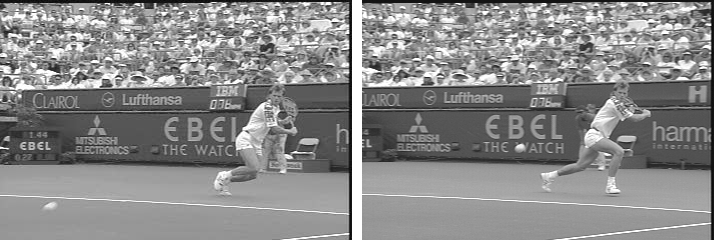

In [127]:
assignment_utils.side_by_side(reference_luma_ds1_ibbp, target_luma_ds_ibbp)

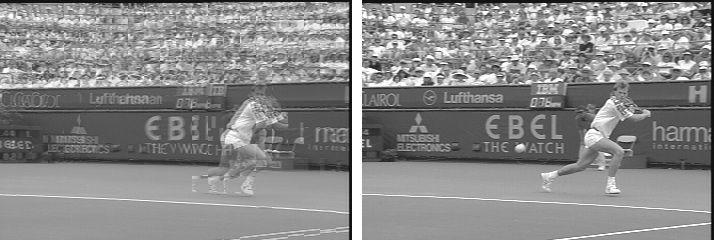

In [128]:
assignment_utils.side_by_side(mc_reference_luma_b_ucbds, target_luma_ds_ibbp)

In [129]:
difference_image_IBBP_DS=assignment_utils.difference_image(reference_luma_ds1_ibbp, mc_reference_luma_b_ucbds)
difference_image_IBBP_DS.save('Assets/Differences/difference_image_ibbp_ds_stefan.png')

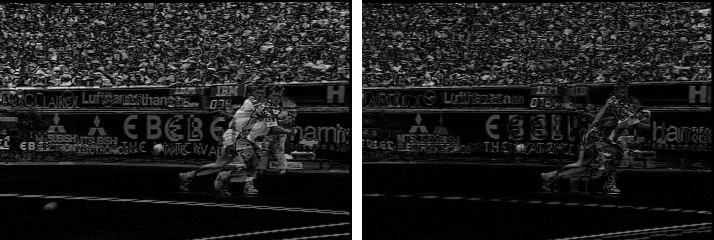

In [130]:
assignment_utils.side_by_side(assignment_utils.difference_image(target_luma_ds_ibbp, reference_luma_ds1_ibbp), \
                              assignment_utils.difference_image(target_luma_ds_ibbp, mc_reference_luma_b_ucbds))

In [59]:
assignment_utils.image_psnr(reference_luma_ds1_ibbp, target_luma_ds_ibbp)

27.915655564479827

In [60]:
assignment_utils.image_psnr(mc_reference_luma_b_ucbds, target_luma_ds_ibbp)

33.12343663692142